<a href="https://colab.research.google.com/github/SuperZarija/Recognizing-the-presence-of-cancer-on-lung-X-rays/blob/main/Recognizing%20the%20presence%20of%20cancer%20on%20lung%20X-rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepoznavanje prisustva raka na rendgenskim snimcima pluća iz predmeta Analiza medicinske slike

In [ ]:
#https://paperswithcode.com/paper/multi-label-chest-x-ray-classification-via
#https://github.com/aravindsp/CS598_DL_Chest_X_RayClassification/blob/main/code/cs-598-multi-labelchest-x-ray-classification.ipynb
#citiraj, uzele smo deo

In [ ]:
!curl -L -o 'INC_QR_pola.rar' 'https://drive.google.com/u/0/uc?id=1GOAsZSWDuXy_RWhISQ8eQ90Xv89h5Jtg&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1474M  100 1474M    0     0  71.7M      0  0:00:20  0:00:20 --:--:-- 81.8M


In [ ]:
#otpakivanje fajlova za trening
# !unzip /content/manja_baza.zip
!unrar x /content/INC_QR_pola.rar

Izlaz streaminga skraćen je na ovoliko posljednjih redaka: 5000.
Extracting  qres/VCX_s0010860_i1_PA.xml                                   63%  OK 
Extracting  qres/VCX_s0010861_i1_PA.jpg                                   63%  OK 
Extracting  qres/VCX_s0010861_i1_PA.xml                                   63%  OK 
Extracting  qres/VCX_s0010862_i1_PA.jpg                                   63%  OK 
Extracting  qres/VCX_s0010862_i1_PA.xml                                   63%  OK 
Extracting  qres/VCX_s0010863_i1_PA.jpg                                   63%  OK 
Extracting  qres/VCX_s0010863_i1_PA.xml                                   63%  OK 
Extracting  qres/VCX_s0010864_i1_PA.jpg                                   63%  OK 
Extracting  qres/VCX_s0010864_i1_PA.xml                                   63%  OK 
Extracting  qres/VCX_s0010865_i1_PA.jpg                                   63%  OK 
Extracting  qre

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets
import lxml.etree
import cv2
import glob
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from copy import copy
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
# #trazenje najmanjih dimenzija da bi smo sve slike sveli na istu dimenziju
# imgs_path = "/content/qres/"
# file_list = glob.glob(imgs_path + "/*.jpg")
# img_list = [cv2.imread(im_file) for im_file in file_list]

# list_height = []
# list_width = []

# for img in img_list:
#   width, height, _ = img.shape
#   list_height.append(height)
#   list_width.append(width)

# set_height = min(list_height)
# set_width = min(list_width)

# print(set_height)
# print(set_width)

# # min(list_height) = 576
# # min(list_width) = 576

In [ ]:
set_height = 224
set_width = 224
#prema njihovom radu 224 i 224

In [ ]:
# #prebrojavamo pozitive i negative u nasem setu
# imgs_path = "/content/qres/" #"/content/manja_baza/"
# file_list = glob.glob(imgs_path + "*")                #ispisuje listu ucitanih slika i xml-ova

# trues = 0
# falses = 0
# for class_path in file_list:
#   if class_path.endswith('xml'):                      #samo u xml fajlovima trazi labele
#     root = lxml.etree.parse(class_path)
#     class_name = root.find('Normal')
#     if class_name.text == 'true':
#       trues += 1
#     else:
#       falses += 1

# print(trues)
# print(falses)

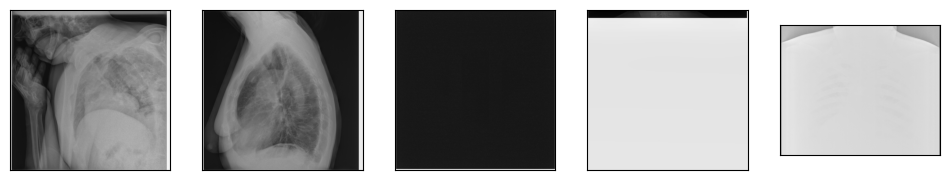

In [ ]:
# lista imena losih slika + dodaj one 2 od gore
bad_images = ['VCX_s0008172_i1_PA', 'VCX_s0008193_i1_PA', 'VCX_s0008811_i1_PA', 'VCX_s0009384_i1_PA',
              'VCX_s0009603_i1_PA', 'VCX_s0009616_i1_PA', 'VCX_s0009624_i1_PA', 'VCX_s0009942_i1_PA',
              'VCX_s0010069_i1_PA', 'VCX_s0010632_i1_PA', 'VCX_s0010632_i2_PA', 'VCX_s0010685_i2_PA',
              'VCX_s0010717_i1_PA', 'VCX_s0010717_i2_PA', 'VCX_s0010718_i1_PA', 'VCX_s0010718_i2_PA',
              'VCX_s0010960_i2_PA', 'VCX_s0011296_i1_PA', 'VCX_s0011591_i1_PA', 'VCX_s0011591_i2_PA',
              'VCX_s0011592_i1_PA', 'VCX_s0012012_i1_PA', 'VCX_s0012138_i2_PA', 'VCX_s0012200_i2_PA',
              'VCX_s0012397_i1_PA', 'VCX_s0012511_i1_PA', 'VCX_s0012512_i1_PA', 'VCX_s0012692_i2_PA', 'VCX_s0001420_i', 'VCX_s0003179_i']

# kreiranje liste putanja do fajlova koje treba izbaciti
path = "/content/qres/"
bad_files = []
for i in bad_images:
    f = path + i + ".xml"
    bad_files.append(f)

# iscrtavanje prvih 5 losih slika
num_of_images = 5
fig = plt.figure(figsize=(12, 8))
for i in range(num_of_images):
  img = cv2.imread(path + bad_images[i] + ".jpg")
  ax = fig.add_subplot(1, num_of_images, 1 + i, xticks=[], yticks=[])
  plt.imshow(img)

In [ ]:
#spisak slika koje treba da se rotiraju
rotated_left = [8550, 8626, 8630, 9862, 10081]
rotated_right = 8526
rotated_down = [8516, 8523, 12336]

In [ ]:
#DataLoader - ucitavanje podataka na kojima ce se obucavati mreza
class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = "/content/qres/" #"/content/manja_baza/"
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)                                      #ispisuje listu ucitanih slika i xml-ova

        #izbacuje slike koje ne sadrže grudni kos
        for i in bad_files:
          file_list.remove(i)

        self.data = []                                        #prazna lista koju kroz for petlju punimo sa slikama i odgovarajucim labelama
        for class_path in file_list:
          if class_path.endswith('xml'):                      #samo u xml fajlovima trazi labele
            root = lxml.etree.parse(class_path)

            #izbacivanje slika koje nisu tehnički validne
            valid = root.find('TechnicallyValid').text
            if valid == 'false':
              continue

            #izbacivanje slika koje koje se ne odnose na pluca
            disease_type = root.find('./AITrainingReports/AITraining/Type')
            if disease_type != None:
              if disease_type.text != 'Oncological':
                continue

            #pridruzivanje ispravnih slika koje se odnose na pluca
            class_name = root.find('Normal')

            img_path = class_path[:-3] + 'jpg'                  #uzmi sve osim poslednja 3, tj uzmi sve osim xml
            if img_path in file_list:
              self.data.append([img_path, class_name.text])     #slikama pridruzi odgovarajuce labele

        print(self.data)
        self.class_map = {"true": 0, "false": 1}

        self.img_dim = (set_height, set_width)

        #normalizacija celog data seta
        self.transforms = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.ToTensor(),
                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      img_path, class_name = self.data[idx]

      img = cv2.imread(img_path)

      img_num = int(img_path[-15:-10])

      # rotiranje za -90 stepeni
      if (img_num >= 8302 and img_num <= 8501) or img_num in rotated_left:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

      # rotiranje za 90 stepeni
      if (img_num >= 10587 and img_num <= 11853) or img_num == 8526:
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

      # rotiranje za 180 stepeni
      if img_num in rotated_down:
        img = cv2.rotate(img, cv2.ROTATE_180)

      #promena dimenzija
      img = cv2.resize(img, self.img_dim)
      class_id = self.class_map[class_name]

      img_transform = self.transforms(img)
      class_id = torch.tensor(class_id)
      return img_transform, class_id

dataset = CustomDataset()
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

['/content/qres/VCX_s0012066_i1_PA.jpg', '/content/qres/VCX_s0010579_i1_PA.xml', '/content/qres/VCX_s0012001_i1_PA.jpg', '/content/qres/VCX_s0000434_i1_PA.jpg', '/content/qres/VCX_s0008797_i1_PA.jpg', '/content/qres/VCX_s0010457_i2_PA.jpg', '/content/qres/VCX_s0008118_i1_PA.jpg', '/content/qres/VCX_s0008226_i1_PA.jpg', '/content/qres/VCX_s0009665_i1_PA.jpg', '/content/qres/VCX_s0000549_i1_PA.xml', '/content/qres/VCX_s0011799_i1_PA.jpg', '/content/qres/VCX_s0000298_i1_PA.jpg', '/content/qres/VCX_s0009877_i1_PA.jpg', '/content/qres/VCX_s0008508_i1_PA.xml', '/content/qres/VCX_s0010144_i1_PA.jpg', '/content/qres/VCX_s0000018_i1_PA.xml', '/content/qres/VCX_s0000372_i1_PA.xml', '/content/qres/VCX_s0010345_i1_PA.jpg', '/content/qres/VCX_s0000673_i1_PA.jpg', '/content/qres/VCX_s0009707_i1_PA.xml', '/content/qres/VCX_s0000772_i1_PA.txt', '/content/qres/VCX_s0009083_i1_PA.jpg', '/content/qres/VCX_s0011317_i1_PA.xml', '/content/qres/VCX_s0010063_i1_PA.xml', '/content/qres/VCX_s0000101_i1_PA.txt',

In [ ]:
# print(len(dataset))

# trues = 0
# falses = 0

# for im, lab in dataset:
#   if lab == 0:
#     trues += 1
#   else:
#     falses += 1

# print(trues)
# print(falses)


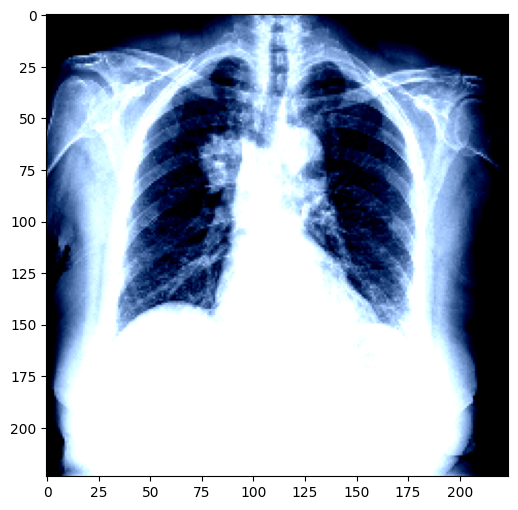

In [ ]:
#prikaz jedne slike iz data seta
im, lab = dataset[0]

plt.figure(figsize=(6, 6))
plt.imshow(im.permute(1, 2, 0))

In [ ]:
#segmentacija dataseta na trening, test i validacioni skup
train_set, test_set, val_set = random_split(dataset, [0.75, 0.10, 0.15], generator=torch.Generator().manual_seed(20))


#Pravimo sempler koji balansira klase po becu da bi smo postigli da u svakom bude priblizno isti broj slika iz obe klase
y_train_indices = train_set.indices

y_train = []

for i in y_train_indices:           # pravljenje liste labela
  if dataset.data[i][1] == 'true':
    y_train.append(0)
  else:
    y_train.append(1)

class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
print(samples_weight)

sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

###

b = 64
train_loader = DataLoader(train_set, batch_size=b, sampler=sampler)

train_set.dataset = copy(dataset)
train_set.dataset.transforms = transforms.Compose([
                                  transforms.ToPILImage(),
                                  #transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.05, 0.2))], p=0.5),
                                  transforms.RandomApply([transforms.RandomAffine(degrees=(-5,5), translate=(0.05, 0.05), scale=(0.95, 1.05))], p=0.7),
                                  #transforms.RandomEqualize(1),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

b = 16
test_loader = DataLoader(test_set, batch_size=b, shuffle=False)

val_loader = DataLoader(val_set, batch_size=b, shuffle=False)

tensor([0.0019, 0.0004, 0.0004,  ..., 0.0019, 0.0004, 0.0004],
       dtype=torch.float64)


In [ ]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

2889
577
385


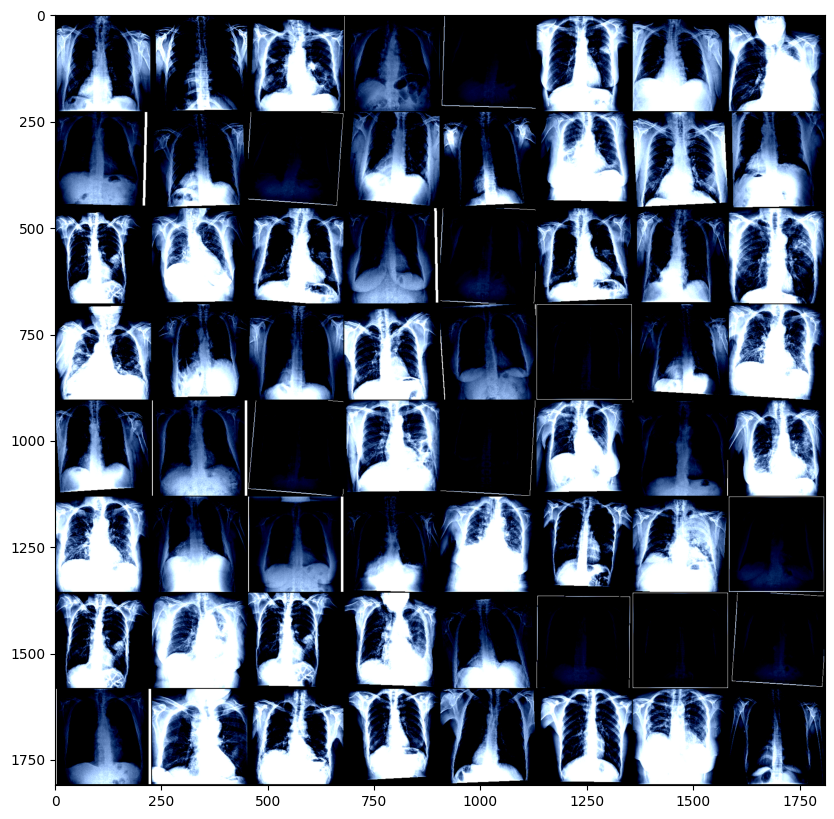

In [ ]:
# iscrtavanje jednog batch-a trening skupa

import numpy as np

def imshow(img):

  npimg = img.numpy()
  plt.figure(figsize=(10, 10))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_loader)

images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

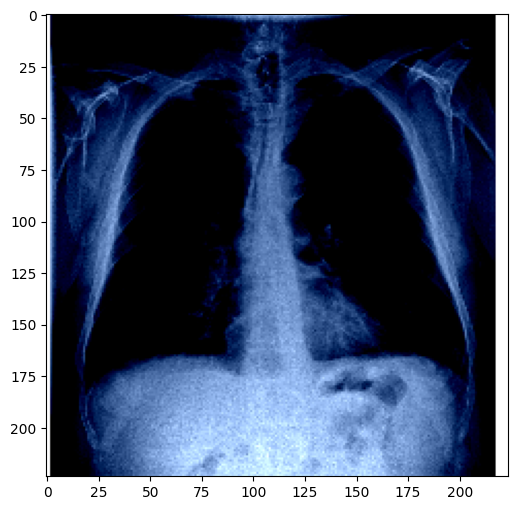

In [ ]:
# slika bez transformacije
im, lab = test_set[0]

plt.figure(figsize=(6, 6))
plt.imshow(im.permute(1, 2, 0))

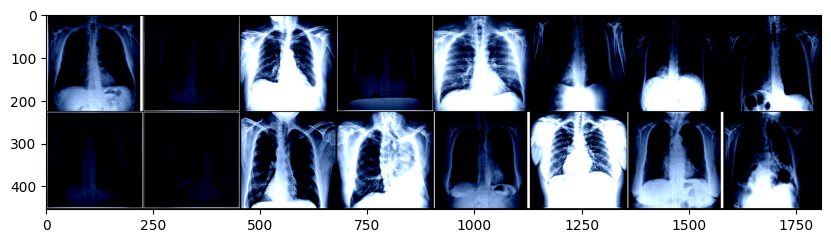

In [ ]:
# iscrtavanje jednog batch-a test skupa

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [ ]:
#model
class CustomNet(nn.Module):
    def __init__(self, num_classes=2, is_trained=False):
        super().__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 8, 3), # inp (3, 512, 512)
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16), #
            nn.MaxPool2d(2),
            nn.ReLU() # op (16, 256, 256)
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(16, 32, 5), # inp (16, 256, 256)
            nn.Conv2d(32, 32, 3),
            nn.BatchNorm2d(32), #
            nn.MaxPool2d(4),
            nn.ReLU() # op (32, 64, 64)
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # inp (32, 64, 64)
            nn.Conv2d(64, 128, 5), #pazi ovde je bilo 64!
            nn.BatchNorm2d(128), #pazi ovde je bilo 64!
            nn.MaxPool2d(2),
            nn.ReLU() # op (64, 32, 32)
        )
        # self.ConvLayer4 = nn.Sequential(
        #     nn.Conv2d(64, 128, 5), # inp (64, 32, 32)
        #     nn.Conv2d(128, 128, 3),
        #     nn.BatchNorm2d(128), #
        #     nn.MaxPool2d(2),
        #     nn.ReLU() # op (128, 16, 16)
        # )
        #self.Lin1 = nn.Linear(15488, 15)
        self.Lin1 = nn.Sequential(nn.Linear(12800, 1), nn.Sigmoid())    #21632/512 u zavisnosti od dim slika

    def forward(self, x):
        # print(x.shape)
        x = self.ConvLayer1(x)
        # print(x.shape)
        x = self.ConvLayer2(x)
        # print(x.shape)
        x = self.ConvLayer3(x)
        # print(x.shape)
        #x = self.ConvLayer4(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.Lin1(x)

        return x

N = CustomNet().to(device)

In [ ]:
#odabir funkcije cene i optimizacionog algoritma v2
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.AdamW(N.parameters(), lr = 0.0001, weight_decay=0.001)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'max', min_lr=1e-6, verbose=True)

In [ ]:
from torch.autograd.variable import Variable
#obuka

epoch_loss_list = []
valEpoch_loss_list = []
epoch_acc_list = []
valEpoch_acc_list = []

N.train()

for epoch in range(50):

  total_loss = 0
  total_loss_val = 0
  epoch_loss = 0
  epoch_loss_val = 0
  correct = 0
  total = 0

  for i, data in enumerate(train_loader, 0):

    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    #print(inputs.shape)
    outputs = N(inputs).to(device)

    loss = criterion(outputs, labels.unsqueeze(1).float())

    #L1/L2 regularizacija
    #Replaces pow(2.0) with abs() for L1 regularization
    l2_lambda = 0.0001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in N.parameters())

    loss = loss + l2_lambda * l2_norm

    loss.backward()
    optimizer.step()

    #trazenje fje cene i tacnosti na trening skupu
    total_loss += loss.item()
    epoch_loss = total_loss/len(train_loader)

    predicted = (outputs > 0.5)

    total += labels.size(0)
    correct += (predicted == labels.view_as(predicted)).sum().item()

  epoch_loss_list.append(epoch_loss)
  epoch_acc_list.append(correct/total*100)

  #trazenje fje cene i tacnosti na validacionom skupu
  correct_val = 0
  total_val = 0
  with torch.no_grad():

    for i, data in enumerate(val_loader, 0):

      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      outputs = N(images).to(device)

      loss_val = criterion(outputs, labels.unsqueeze(1).float())

      total_loss_val += loss_val.item()
      epoch_loss_val = total_loss_val/len(val_loader)

      predicted = (outputs > 0.5)

      total_val += labels.size(0)
      correct_val += (predicted == labels.view_as(predicted)).sum().item()

    lr_scheduler.step(correct_val/total_val*100)

    valEpoch_loss_list.append(epoch_loss_val)
    valEpoch_acc_list.append(correct_val/total_val*100)

  print(epoch, 'Epoch loss:', epoch_loss, ', Accuracy:', correct/total*100 ,'%,', 'Epoch loss on validation set:', epoch_loss_val ,', Accuracy on validation set:', correct_val/total_val*100,'%')

print('Finished')

0 Epoch loss: 0.5893049790807392 , Accuracy: 71.58186223606783 %, Epoch loss on validation set: 0.5076243740481299 , Accuracy on validation set: 79.37608318890814 %
1 Epoch loss: 0.5035879139019095 , Accuracy: 77.95084804430599 %, Epoch loss on validation set: 0.4921607181832597 , Accuracy on validation set: 77.12305025996534 %
2 Epoch loss: 0.4845248091480006 , Accuracy: 80.02769124264452 %, Epoch loss on validation set: 0.5186224394553417 , Accuracy on validation set: 75.90987868284229 %


KeyboardInterrupt: ignored

In [ ]:
#uporedjivanje lossa na trening i val skupu
plt.plot(epoch_loss_list, label='train_loss')
plt.plot(valEpoch_loss_list,label='val_loss')
plt.legend()
plt.show

In [ ]:
#uporedjivanje tacnosti na trening i val skupu
plt.plot(epoch_acc_list, label='train_accuracy')
plt.plot(valEpoch_acc_list,label='val_accuracy')
plt.legend()
plt.show

In [ ]:
#tacnost na test skupu
correct = 0
total = 0

N.eval()
4. poster (andrija)

with torch.no_grad():
  target_list = []
  preds_list = []

  for i, data in enumerate(test_loader, 0):

      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      target_list.extend(labels.cpu().numpy())

      outputs = N(images).to(device)
      #print(outputs)

      predicted = (outputs > 0.5)
      #print(predicted)
      preds_list.extend(predicted.cpu().numpy())
      #print(preds_list)

      total += labels.size(0)
      #print(total)
      correct += (predicted == labels.view_as(predicted)).sum().item()
      #print(correct)

  print('Accuracy', correct/total*100., '%')

  #matrica konfuzije
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc

  target = torch.tensor(target_list)
  preds = torch.tensor(preds_list)

  cm = confusion_matrix(target, preds)
  ConfusionMatrixDisplay(cm).plot()

  #ROC kriva
  fpr, tpr, thresholds = roc_curve(target,preds)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
  display.plot()
  plt.show()

In [ ]:
#tacnost po klasama na test skupu
classes = ('no cancer', 'cancer')

correct_class = {classname: 0 for classname in classes}
total_class = {classname: 0 for classname in classes}

with torch.no_grad():

  for i, data in enumerate(test_loader, 0):

      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      outputs = N(images).to(device)

      predicted = (outputs > 0.5)

      for label, prediction in zip(labels, predicted):
        total_class[classes[label]] += 1
        if label == prediction:
          correct_class[classes[label]] += 1

  for classname, corr_count in correct_class.items():
    accuracy = 100 * corr_count / total_class[classname]
    print('Accuracy for class', classname, 'is', accuracy, '%')

In [ ]:
PATH ='./model.pth'
torch.save(N.state_dict(), PATH)

In [ ]:
PATH ='./model.pth'
N = CustomNet().to(device)
N.load_state_dict(torch.load(PATH))

In [ ]:
# putanja do slike
image_path = "/content/VCX_s0000007_i1_PA.jpg"

# ucitavanje i transformisanje slike
img = cv2.imread(image_path)
img = cv2.resize(img, (224, 224))

transform = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.ToTensor(),
                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                              ])

img = transform(img)

# pravljenje batch-a koji sadrzi jednu sliku
img = img.to(device).unsqueeze(0) # unsqueeze(0) da bi bio 4D tenzor (1, 3, 224, 224); (batch=1)

# propustanje slike kroz mrezu
output = N(img).to(device)
predicted = (output > 0.5).float()

# mapiranje izlaza 0 ili 1 u no cancer ili cancer
classes = ('no cancer', 'cancer')

result = classes[predicted.cpu().int()[0][0]]
print(result)